In [1]:
# merge the diag_ges and diag_anl files into panda dataframe
# so it can be easier to compare the DA effect from same obs
# initial built: 2025/02/06

# This has been transformed into py file at 2025/02/14:
# /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/compile_single_cycle_radstat.py

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import cartopy

'sc_CTRL-sc_amsua_ch1'

In [14]:
#exps = ['sc_CTRL', 'sc_amsua_ch3']
exps = ['sc_CTRL', 'sc_full_clr_cld']
#exps = ['sc_CTRL', 'sc_multichannel']

instr='atms'
#sat='n15'
sat='n20'
#time='2022070106'
#time='2022073100'
time=''

gesanl=['ges', 'anl']
if instr == 'amsua':
    all_sky_channels = [1,2,3,4,5,15]
elif instr == 'atms':
    all_sky_channels = [1,2,3,4,5,6,16,17,18,19,20,21,22]

In [15]:
root={};
for exp in exps:
    if exp.startswith('sc_'):
        exp_tmp = exp.split('sc_')[1]
        #root[exp] = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/amsua/single_cycle_VarBC_sens_exp/varbc_sens_{exp_tmp}'
        root[exp] = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/amsua/single_cycle_VarBC_sens_exp_v2/varbc_sens_v2_{exp_tmp}'


In [16]:
df={};
df_name = [];

for exp in exps:
    for ga in gesanl:
        
        df_name_tmp = f'{exp}_{ga}'
        df_name.append(df_name_tmp)
        
        fn = f'diag_{instr}_{sat}_{ga}.{time}.nc4'
        rr = nc.Dataset(f"{root[exp]}/{fn}")

        print(f'processing {df_name_tmp}...')

        # transform selected data into panda dataframe:
        data = {
            "channel": rr.variables['Channel_Index'][:],
            "lat":     rr.variables['Latitude'][:],
            "lon":     rr.variables['Longitude'][:],
            "fwater":  rr.variables['Water_Fraction'][:],
            "qc":      rr.variables['QC_Flag'][:],

            "obs":     rr.variables['Observation'][:],
            "omf":     rr.variables['Obs_Minus_Forecast_adjusted'][:],
            "omfnbc":  rr.variables['Obs_Minus_Forecast_unadjusted'][:],

            "clw_obs":   rr.variables['clw_obs'][:],
            "clw_model": rr.variables['clw_guess_retrieval'][:],
            "clw_sym":   0.5*(rr.variables['clw_obs'][:] + rr.variables['clw_guess_retrieval'][:]),
            
            "inv_obserr": rr.variables['Inverse_Observation_Error'][:],
            'omfnorm':    rr.variables['Obs_Minus_Forecast_adjusted'][:]*(rr.variables['Inverse_Observation_Error'][:]**2)
        }

        # optional additional variables:
        if 'VarBC_Data_Control_Index' in rr.variables:
            data["varbc_idx"] = rr.variables['VarBC_Data_Control_Index'][:]

        if 'Inner_domain_Pressure' in rr.variables: # if save Jacobian information:
            data["inner_pres"] = rr.variables['Inner_domain_Pressure'][:].tolist()
            data["inner_t"]    = rr.variables['Inner_domain_Temperature'][:].tolist()
            data["inner_qv"]   = rr.variables['Inner_domain_Water_Vapor'][:].tolist()
            data["inner_ql"]   = rr.variables['Inner_domain_ql'][:].tolist()
            data["jac_t"]      = rr.variables['Jacobian_Temperature'][:].tolist()
            data["jac_qv"]     = rr.variables['Jacobian_Water_Vapor'][:].tolist()
            data["jac_ql"]     = rr.variables['Jacobian_ql'][:].tolist()

        tmpdf = pd.DataFrame(data)

        ### filtered criteria ###

        # only passed QC data:
        tmpdf2 = tmpdf[tmpdf["qc"] == 0]

        # only all-sky data:
        df[df_name_tmp] = tmpdf2[tmpdf2['channel'].isin(all_sky_channels)]

        del data

        #########################

processing sc_CTRL_ges...
processing sc_CTRL_anl...
processing sc_full_clr_cld_ges...
processing sc_full_clr_cld_anl...


In [6]:
df_name

['sc_CTRL_ges', 'sc_CTRL_anl', 'sc_full_clr_cld_ges', 'sc_full_clr_cld_anl']

In [17]:
# merge all dataframes:

merge_keys = ["channel", "lon", "lat", "fwater", "obs", "clw_obs"]
merged_df = df[df_name[0]].copy()  # Start with the first DataFrame

rename_columns = {col: f"{col}_{df_name[0]}" for col in merged_df.columns if col not in merge_keys}
merged_df.rename(columns=rename_columns, inplace=True)

# Iterate through the remaining DataFrames and merge
for name in df_name[1:]:
    df_temp = df[name].copy()

    # Rename all columns except the merge keys to avoid conflicts
    rename_columns = {col: f"{col}_{name}" for col in df_temp.columns if col not in merge_keys}
    df_temp.rename(columns=rename_columns, inplace=True)

    # Merge the DataFrame with the renamed columns
    merged_df = merged_df.merge(df_temp, on=merge_keys, how="inner")
    
# Reorder columns: merge keys first, followed by the remaining columns
new_column_order = merge_keys + [col for col in merged_df.columns if col not in merge_keys]
merged_df = merged_df[new_column_order]

In [26]:
merged_df.keys()

Index(['channel', 'lon', 'lat', 'fwater', 'obs', 'clw_obs', 'qc_sc_CTRL_ges',
       'omf_sc_CTRL_ges', 'omfnbc_sc_CTRL_ges', 'clw_model_sc_CTRL_ges',
       'clw_sym_sc_CTRL_ges', 'varbc_idx_sc_CTRL_ges',
       'inner_pres_sc_CTRL_ges', 'inner_t_sc_CTRL_ges', 'inner_qv_sc_CTRL_ges',
       'inner_ql_sc_CTRL_ges', 'jac_t_sc_CTRL_ges', 'jac_qv_sc_CTRL_ges',
       'jac_ql_sc_CTRL_ges', 'qc_sc_CTRL_anl', 'omf_sc_CTRL_anl',
       'omfnbc_sc_CTRL_anl', 'clw_model_sc_CTRL_anl', 'clw_sym_sc_CTRL_anl',
       'varbc_idx_sc_CTRL_anl', 'inner_pres_sc_CTRL_anl',
       'inner_t_sc_CTRL_anl', 'inner_qv_sc_CTRL_anl', 'inner_ql_sc_CTRL_anl',
       'jac_t_sc_CTRL_anl', 'jac_qv_sc_CTRL_anl', 'jac_ql_sc_CTRL_anl',
       'qc_sc_amsua_ch1_ges', 'omf_sc_amsua_ch1_ges',
       'omfnbc_sc_amsua_ch1_ges', 'clw_model_sc_amsua_ch1_ges',
       'clw_sym_sc_amsua_ch1_ges', 'varbc_idx_sc_amsua_ch1_ges',
       'inner_pres_sc_amsua_ch1_ges', 'inner_t_sc_amsua_ch1_ges',
       'inner_qv_sc_amsua_ch1_ges', 'inn

In [18]:
output_root = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/pkl_files_multi_exp'
output_fn   = f"{instr}_{sat}_gesanl_{time}_{'-'.join(exps)}.pkl"

merged_df.to_pickle(f"{output_root}/{output_fn}")

'amsua_n15_gesanl_2022070106_sc_CTRL-sc_amsua_ch1.csv'

In [ ]:
# several useful tips:

# group the rows into "observation data point"
# each data point = an observation at a certain location:
group_df = merged_df.groupby(['lat', 'lon'])

# to see the # of data point:
ndata = len(list(group_df))
print(f'# of data point = {ndata}')

# to check the data frame of a specific data point:
#data_idx = 0
#list(group_df)[data_idx][1]

# to retrieve the data from group_df:
for key, group in group_df:
    print(key)
#    print(type(group))

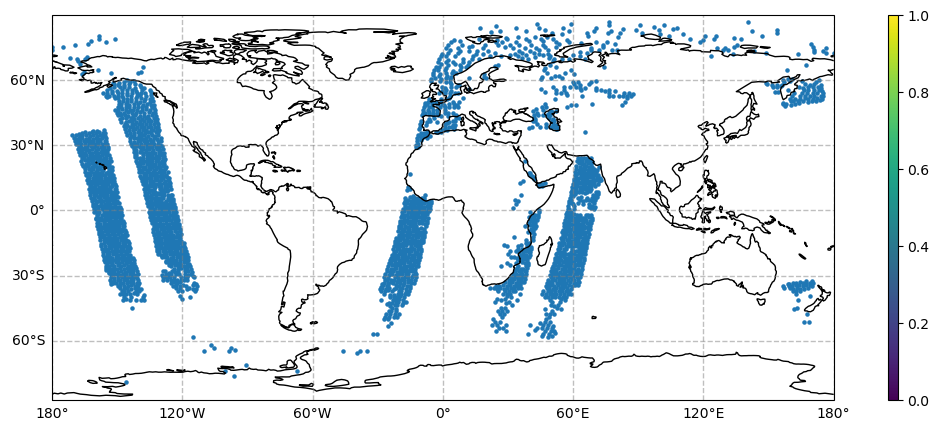

In [46]:
# Examples:

# Plot the data point distribution:

# retrieve the data point:
latd = []; lond = []; 

for key, group in group_df:
    latd.append(key[0])
    lond.append(key[1])    

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.coastlines()
scatter1 = ax.scatter(lond, latd, s=5)

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Hide labels on the top side
gl.right_labels = False  # Hide labels on the right side
#ax.set_title(f'{exptest} -  {expref}  {instr}-{sat} channel-{chn} {gesanl} {time}')
cbar = fig.colorbar(scatter1,location='right',aspect=40)
#cbar.set_label('dT (K)', fontsize=14)


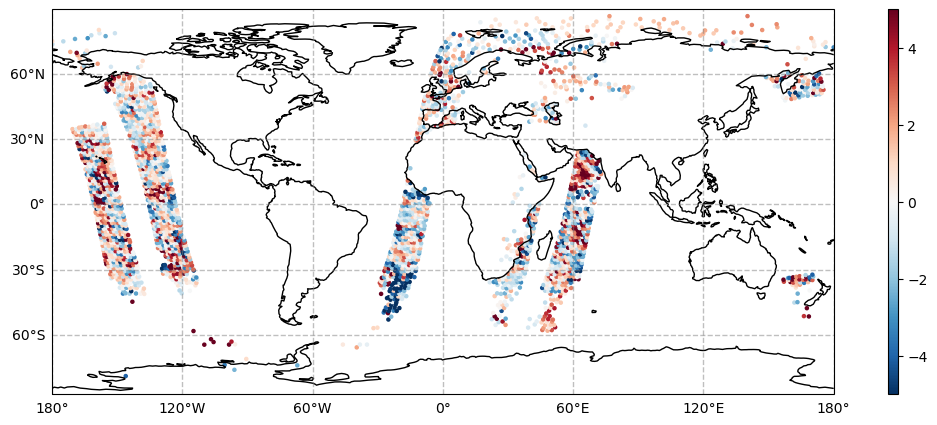

In [50]:
# Examples 
# Plot CH1 omf spatial distribution:

tmpdf = merged_df[merged_df['channel'] == 1]
lond = tmpdf['lon']
latd = tmpdf['lat']
omfd = tmpdf['omf_ges']

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.coastlines()
scatter1 = ax.scatter(lond, latd, c=omfd, s=5,  vmin=-5, vmax=5, cmap='RdBu_r')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Hide labels on the top side
gl.right_labels = False  # Hide labels on the right side
#ax.set_title(f'{exptest} -  {expref}  {instr}-{sat} channel-{chn} {gesanl} {time}')
cbar = fig.colorbar(scatter1,location='right',aspect=40)
#cbar.set_label('dT (K)', fontsize=14)

In [ ]:
latd

In [68]:
idx = 1

sel_df = merged_df[merged_df["channel"]==1]
testcase = sel_df.iloc[idx]

lat = testcase['lat']
lon = testcase['lon']
fwater = testcase['fwater']
ch  = testcase['channel']
omf = testcase['omf_ges']
qv_ges = np.array(testcase['inner_qv_ges'])
qv_anl = np.array(testcase['inner_qv_anl'])

jac_qv_ges = np.array(testcase['jac_qv_ges'])

pres_ges = np.array(testcase['inner_pres_ges'])
pres_anl = np.array(testcase['inner_pres_anl'])

Text(0.5, 1.0, 'lat = -54.2, lon = 25.7, fwater = 1.00, ch1-omf = -1.3')

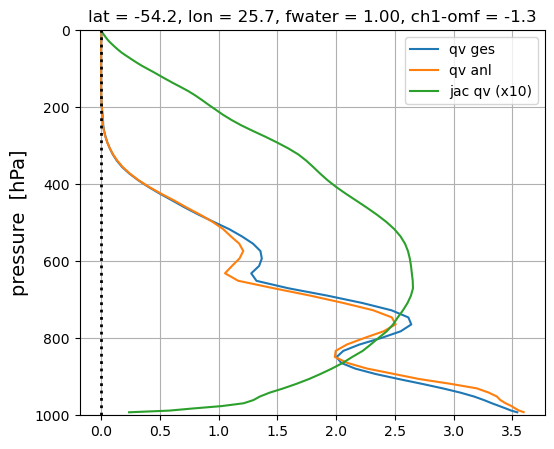

In [69]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(qv_ges, pres_ges, label='qv ges')
ax.plot(qv_anl, pres_anl, label='qv anl')
ax.plot(jac_qv_ges*10, pres_ges, label='jac qv (x10)')
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_ylim(1000,0)
#ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.legend()
ax.set_title(f'lat = {lat:.1f}, lon = {lon:.1f}, fwater = {fwater:.2f}, ch{ch}-omf = {omf:.1f}')

In [63]:
sel_df

,channel,lat,lon,fwater,qc_ges,obs,omf_ges,omfnbc_ges,clw_obs,clw_model_ges,...,clw_model_anl,clw_sym_anl,varbc_idx_anl,inner_pres_anl,inner_t_anl,inner_qv_anl,inner_ql_anl,jac_t_anl,jac_qv_anl,jac_ql_anl
939,1,-55.493698,24.270300,1.0,0.0,162.179993,-0.484544,2.684738,0.244823,0.231449,...,0.214534,0.229678,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[247.30149841308594, 247.30149841308594, 247.3...","[0.00252518174238503, 0.00252518174238503, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.5594436263199896e-05, 5.746262104366906e-06...","[-7.207884482340887e-05, -7.813386764610186e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
994,1,-54.194698,25.682600,1.0,0.0,156.660004,-1.313984,1.880437,0.125756,0.112478,...,0.113914,0.119835,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[248.32635498046875, 248.32635498046875, 248.3...","[0.0027619742322713137, 0.0027619742322713137,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.64946341101313e-05, 6.076643330743536e-06, ...","[-8.198294381145388e-05, -8.91513263923116e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1007,1,-53.900799,27.504499,1.0,0.0,161.679993,4.266596,7.418615,0.119857,0.070282,...,0.068233,0.094045,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[248.868896484375, 248.868896484375, 248.86889...","[0.002693390706554055, 0.002693390706554055, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6614198102615774e-05, 6.121259048086358e-06...","[-9.739913366502151e-05, -0.000106698149465955...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1050,1,-52.816002,22.506201,1.0,0.0,152.630005,-1.075423,1.845636,0.054032,0.110078,...,0.092466,0.073249,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[247.86622619628906, 247.86622619628906, 247.8...","[0.002914524171501398, 0.002914524171501398, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.682922629697714e-05, 6.199298240971984e-06,...","[-0.00011865971464430913, -0.00013163336552679...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1063,1,-52.631699,24.810101,1.0,0.0,166.550003,6.298295,9.464586,0.230623,0.163700,...,0.174237,0.202430,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[248.8330078125, 248.8330078125, 248.833007812...","[0.0028693375643342733, 0.0028693375643342733,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.568248808325734e-05, 5.7749543884710874e-06...","[-9.843843145063147e-05, -0.000108580956293735...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62724,1,66.014900,356.595398,1.0,0.0,197.529999,3.058159,4.481621,0.183475,0.086753,...,0.089620,0.136547,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[267.1147766113281, 267.1147766113281, 267.114...","[0.0030895089730620384, 0.0030895089730620384,...","[1.000999986899842e-06, 1.000999986899842e-06,...","[1.209770289278822e-05, 4.083420662936987e-06,...","[-0.00010756342089734972, -0.00011775001621572...","[31.304615020751953, 31.304615020751953, 31.30..."
62737,1,65.915199,358.423096,1.0,0.0,189.279999,-8.719309,-7.065076,0.063380,0.195871,...,0.174824,0.119102,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[267.0794982910156, 267.0794982910156, 267.079...","[0.003168489784002304, 0.003168489784002304, 0...","[1.000999986899842e-06, 1.000999986899842e-06,...","[1.207296099892119e-05, 4.105444986635121e-06,...","[-0.00010657474194886163, -0.00011702682240866...","[28.8315486907959, 28.8315486907959, 28.831548..."
62750,1,68.347099,357.569214,1.0,0.0,177.699997,-4.346506,-3.006352,0.080766,0.080606,...,0.084443,0.082604,1.0,"[0.17350132763385773, 0.5105040073394775, 0.84...","[267.93511962890625, 267.93511962890625, 267.9...","[0.0032425886020064354, 0.0032425886020064354,...","[1.000999986899842e-06, 1.000999986899842e-06,...","[1.4441304301726632e-05, 4.85471309730201e-06,...","[-0.00013373148976